<a href="https://www.kaggle.com/code/mohamedadlyi/head-pose-estimation?scriptVersionId=165314282" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Installing MediaPipe

In [61]:
%%capture
!pip install mediapipe
%matplotlib inline

### Required Libraries

In [62]:
import numpy as np
import os
import cv2
import math
import glob
import random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import seaborn as sns
import mediapipe as mp
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import pickle
# Suppress warnings
warnings.filterwarnings('ignore')

# Face mesh module
faceModule = mp.solutions.face_mesh


In [63]:
directory = '/kaggle/input/aflw2000-3d/AFLW2000'
print(len(os.listdir(directory)))

4001


### Downloading Data

In [64]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

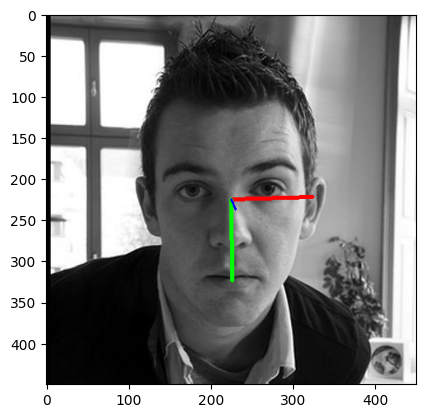

In [65]:
# visualizing data sample

random_file = 'image00379'
# Define the paths to the image and MAT file
image_path = f'{directory}/{random_file}.jpg'
mat_file_path = f'{directory}/{random_file}.mat'

# Load the image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is not None:
    # Load the MAT file to extract the 3 angles of the face (pitch, yaw, roll)
    mat_file = sio.loadmat(mat_file_path)

    # Extract the labels for the 3 angles
    pose_para = mat_file["Pose_Para"][0][:3]
    pitch, yaw, roll = pose_para[0], pose_para[1], pose_para[2]
    
    # Draw axes on the image
    image_with_axes = draw_axis(image, pitch, yaw, roll)

    # Display the image with axes
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

else:
    print(f"Error: Unable to load the image from {image_path}.")


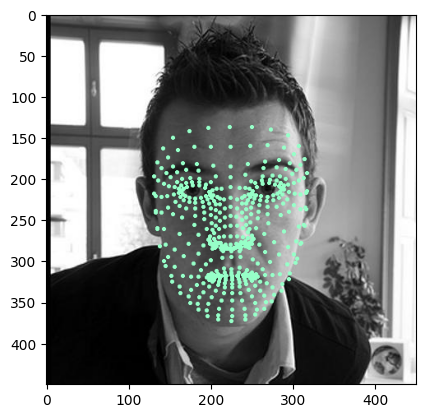

In [66]:
# visualizing media pipe face detection output

face_mesh_module = faceModule.FaceMesh(static_image_mode=True)
image = cv2.imread(image_path)

if image is not None:
    # Convert the image to RGB format (required for Mediapipe)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image to extract landmark points
    results = face_mesh_module.process(image_rgb)

    # Check if landmarks were detected
    if results.multi_face_landmarks:
        width, height = image_rgb.shape[:2]

        # Loop over each detected face
        for face_landmarks in results.multi_face_landmarks:
            # Loop over each landmark point
            for landmark in face_landmarks.landmark:
                # Get the landmark coordinates
                x = int(landmark.x * width)
                y = int(landmark.y * height)

                # Draw a circle at the landmark point
                cv2.circle(image_rgb, (x, y), radius=1, color=(150, 255, 200), thickness=2)
    plt.imshow(image_rgb)


### Preparing Data

In [67]:
files = glob.glob(f'{directory}/*.jpg')


In [68]:
# Lists to store data
images = []
marks_values = []
pitch = []
yaw = []
roll = []

# Iterate over image files
with faceModule.FaceMesh(static_image_mode=True) as faces:

    for i, file in enumerate(files):
#         if i > 2:
#             break
        image = cv2.imread(file)
        if image is None:
            print(f'Failed to load file {file.split("AFLW2000")[-1]}')
            continue

        mat_file = file.replace('jpg', 'mat')
        mat_file = sio.loadmat(mat_file)
        if mat_file is None:
            print(f'Failed to load file {mat_file.split("AFLW2000")[-1]}')
            continue

        # Convert the image to RGB format (required for Mediapipe)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image to extract landmark points
        results = faces.process(image_rgb)
        
        if results.multi_face_landmarks is None :
            continue
            
        # Extract x and y values from results
        height, width = image_rgb.shape[:2]

        x_val = [lm.x*width  for lm in results.multi_face_landmarks[0].landmark]
        y_val = [lm.y*height  for lm in results.multi_face_landmarks[0].landmark]
        
#         centering around the nose landmark
        x_val = np.array(x_val)-np.mean(x_val[1])#[1]
        y_val = np.array(y_val)- np.mean(y_val[1])#[1]
        
#         normalizing based on the average distance from chin to head and from ear to ear 
        x_val = x_val / x_val.max()#[366] #- x_val[137]) / 2)
        y_val = y_val / y_val.max()#[152]  #- y_val[152]) / 2)
        
        
        # Extract labels from mat file
        pose_para = mat_file["Pose_Para"][0][:3]
        p, y, r = pose_para[0], pose_para[1], pose_para[2]
        
        # Append values to lists
        marks_values.append(np.concatenate([x_val,y_val]))
        pitch.append(p)
        yaw.append(y)
        roll.append(r)
        images.append(file.split("image")[-1].split('.')[0][1:])

# Create DataFrame
data = {
    'Image_Id': images,
    'marks_Values': marks_values,
    'Pitch': pitch,
    'Yaw': yaw,
    'Roll': roll
}
data
df = pd.DataFrame(data)


In [69]:
df.head()

,Image_Id,marks_Values,Pitch,Yaw,Roll
0,3479,"[-0.2025875318796764, 0.0, -0.1600067559579104...",0.056265,-0.289151,-0.122998
1,0558,"[0.10384806712848993, 0.0, 0.06656562180574079...",-0.334248,0.330571,-0.149707
2,1352,"[-0.18748607551067714, 0.0, -0.155719673868768...",-0.235049,-0.290742,-0.006371
3,0490,"[0.03802898305973061, 0.0, 0.02279933729712732...",-0.163529,0.102630,-0.082840
4,2795,"[-0.025034925012346006, 0.0, -0.10047898884693...",-0.134659,-0.378369,-0.554895


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Image_Id      1853 non-null   object 
 1   marks_Values  1853 non-null   object 
 2   Pitch         1853 non-null   float64
 3   Yaw           1853 non-null   float64
 4   Roll          1853 non-null   float64
dtypes: float64(3), object(2)
memory usage: 72.5+ KB


In [71]:
df.describe()

,Pitch,Yaw,Roll
count,1853.000000,1853.000000,1853.000000
mean,-0.095366,0.013611,-0.033167
std,0.549292,0.580266,0.649282
min,-12.457202,-6.130066,-16.969362
25%,-0.246453,-0.256714,-0.160274
50%,-0.123371,0.019403,-0.017463
75%,0.028133,0.305791,0.126460
max,15.598820,3.277500,2.166107


In [72]:
def map_to_pi(angle):
    """
    Maps an angle to the range [-π, π].
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi


In [73]:
df[['Pitch', 'Yaw', 'Roll']] = df[['Pitch', 'Yaw', 'Roll']].apply(map_to_pi)

In [74]:
df.describe()

,Pitch,Yaw,Roll
count,1853.000000,1853.000000,1853.000000
mean,-0.098757,0.013611,-0.006040
std,0.298296,0.561701,0.340730
min,-2.864633,-3.005685,-1.944989
25%,-0.246453,-0.256714,-0.159251
50%,-0.123371,0.019403,-0.015933
75%,0.028133,0.304979,0.128125
max,3.032449,1.489062,2.778426


In [75]:
X = np.array(df['marks_Values'].to_list())

# Combine labels into a target array
y = np.array(df[['Pitch', 'Yaw', 'Roll']])
print(X.shape, y.shape)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(1853, 936) (1853, 3)


### Training the model

In [76]:

# Initialize the regression algorithm 
# regressor = ElasticNet(alpha= 1e-5, l1_ratio = 0.4, random_state=0)
# regressor = DecisionTreeRegressor(max_depth=4, min_samples_split=4, random_state=0)
regressor = SVR(kernel='rbf',C=3,gamma=0.005,degree=3,epsilon=0.005)
# regressor = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=0)
# regressor = KNeighborsRegressor(n_neighbors=8)

# Initialize the MultiOutputRegressor with the chosen algorithm

multi_output_regressor = MultiOutputRegressor(regressor)

# Train the multi-output regression model
multi_output_regressor.fit(X_train, y_train)

# Make predictions on the test set
predictions = multi_output_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

print(f'MedAPE score: {np.median(np.abs((y_test - predictions) / y_test), axis = None) * 100}')
print(f'MedSPE score: {np.median(((y_test - predictions) ** 2 / y_test) * 100, axis = None)}')
print(f'r2_score is : {r2_score(y_test, predictions)}')


Mean Squared Error: 0.03378916484336413
MedAPE score: 22.766191310817796
MedSPE score: -0.06389707000905293
r2_score is : 0.7026673368080866


In [77]:
filename = 'SVR_model.sav'
pickle.dump(multi_output_regressor, open(filename, 'wb'))


In [78]:
svr = pickle.load(open('SVR_model.sav', 'rb'))

In [79]:
# # Define a dictionary of regressors with hyperparameters
# regressors = {
#     'Linear Regression': LinearRegression(),
#     'Ridge': Ridge(),
#     'Lasso': Lasso(),
#     'ElasticNet': ElasticNet(),
#     'Decision Tree': DecisionTreeRegressor(),
#     'SVR': SVR(),
#     'Random Forest': RandomForestRegressor()
# }

# # Define hyperparameters for each regressor
# param_grid = {
#     'Linear Regression': {},
#     'Ridge': {'alpha': [0.1, 1.0, 10.0]},
#     'Lasso': {'alpha': [0.1, 1.0, 10.0]},
#     'ElasticNet': {},
#     'Decision Tree': {'max_depth': [None, 5, 10]},
#     'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
#     'SVR': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1.0, 10.0]}
# }

# # Iterate through each regressor and search for best hyperparameters
# for name, regressor in regressors.items():
#     print(f"Searching hyperparameters for {name}...")
#     search = GridSearchCV(regressor, param_grid[name], cv=5, scoring='neg_mean_squared_error')
#     search.fit(X, y)
#     best_params = search.best_params_
#     best_score = search.best_score_
#     print(f"Best parameters: {best_params}")
#     print(f"Best score: {best_score}")

#     # Evaluate the performance of the best model
#     best_model = search.best_estimator_
#     y_pred = best_model.predict(X)
#     mse = mean_squared_error(y, y_pred)
#     print(f"MSE on training data: {mse}")
#     print()


In [80]:
def preprocess(face, width = 450, height = 450):

    x_val = [lm.x*width  for lm in face.landmark]
    y_val = [lm.y*height  for lm in face.landmark]

#         centering around the nose landmark
    x_val = np.array(x_val)- np.mean(x_val[1]) #x_val[1]
    y_val = np.array(y_val)- np.mean(y_val[1]) #[1]

#         normalizing based on the average distance from chin to head and from ear to ear 
    x_val = x_val / x_val.max()#[366] #- x_val[137]) / 2)
    y_val = y_val / y_val.max()#[152]  #- y_val[152]) / 2)
    
    return np.concatenate([x_val,y_val])

In [81]:
def get_file(files):
    for f in files:
        yield f

In [82]:
iter_2 = get_file(files) 

### Visualizing the output with comparison to the original data

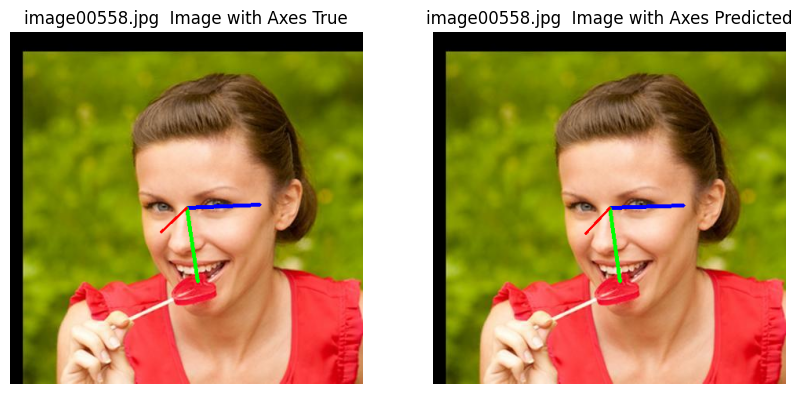

In [88]:
image_path = next(iter_2)
# Define the paths to the image and MAT file

mat_file = image_path.replace('jpg', 'mat')

# Load the image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is not None:
    # Load the MAT file to extract the 3 angles of the face (pitch, yaw, roll)
    mat_file = sio.loadmat(mat_file)

    # Extract the labels for the 3 angles
    pose_para = mat_file["Pose_Para"][0][:3]
    pitch, yaw, roll = pose_para[0], pose_para[1], pose_para[2]
    
    # Draw axes on the image
    image_with_axes = draw_axis(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), pitch, yaw, roll)
    
    # Convert the image to RGB format (required for Mediapipe)
    image_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    

    # Process the image to extract landmark points
    results = face_mesh_module.process(image_rgb)

    # Check if landmarks were detected
    if results.multi_face_landmarks:
        face = results.multi_face_landmarks[0]
        angles = multi_output_regressor.predict(preprocess(face).reshape(1,-1))
        pitch, yaw, roll = angles[0,0], angles[0,1], angles[0,2]
        image_with_axes2 = draw_axis(image_rgb, pitch, yaw, roll)
        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the original image
        tit = image_path.split("AFLW2000/")[-1]
        
        axes[0].imshow(image_with_axes)
        axes[0].set_title(f'{tit}  Image with Axes True')
        axes[0].axis('off')
        # Plot the image with axes
        axes[1].imshow(image_with_axes2)
        axes[1].set_title(f'{tit}  Image with Axes Predicted')
        axes[1].axis('off')
        plt.show()
else:
    print(f"Error: Unable to load the image from {image_path}.")


In [84]:
directory_2 = '/kaggle/input/human-faces/Humans'
files_3 = glob.glob(f'{directory_2}/*.jpg')
print(len(files_3))
iter_3 = get_file(files_3)


6973


### Testing on new data

-0.1265941504263796 0.09242962498784535 -0.08443888331999724
1 (6835).jpg


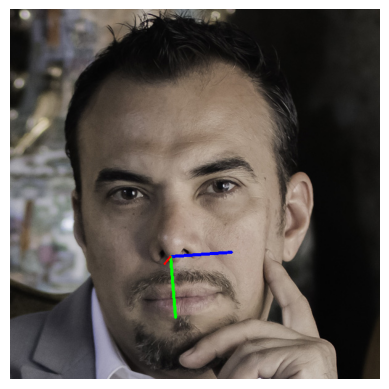

In [100]:
image_path = next(iter_3)
# image_path = f'{directory_2}/1 (1).jpg'
# Load the image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is not None:

    # Convert the image to RGB format (required for Mediapipe)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    # Process the image to extract landmark points
    results = face_mesh_module.process(image_rgb)

    # Check if landmarks were detected
    if results.multi_face_landmarks:
        face = results.multi_face_landmarks[0]
        
        width, height = image_rgb.shape[:2]
        
        angles = multi_output_regressor.predict(preprocess(face, width, height).reshape(1,-1))
        pitch, yaw, roll = angles[0,0], angles[0,1], angles[0,2]
        center = face.landmark[1]
        print(pitch, yaw, roll)
        image_with_axes = draw_axis(image_rgb, pitch, yaw, roll, tdx = center.x * height, tdy = center.y * width )
        # Create subplots

        # Plot the original image
        tit = image_path.split("Humans/")[-1]
        print(tit)
        plt.imshow(image_with_axes)
#         plt.set_title(f'{tit}  Image with Axes True')
        plt.axis('off')

else:
    print(f"Error: Unable to load the image from {image_path}.")


In [86]:
mp_drawing = mp.solutions.drawing_utils

### Testing on new data and comparing with estimation by calculating the euler angle


-0.2187902225428934 0.041183239431574314 -0.008769892945572257
1 (550).jpg
0.0822964821748787 -0.011466445735110856 -0.0004813948757191086


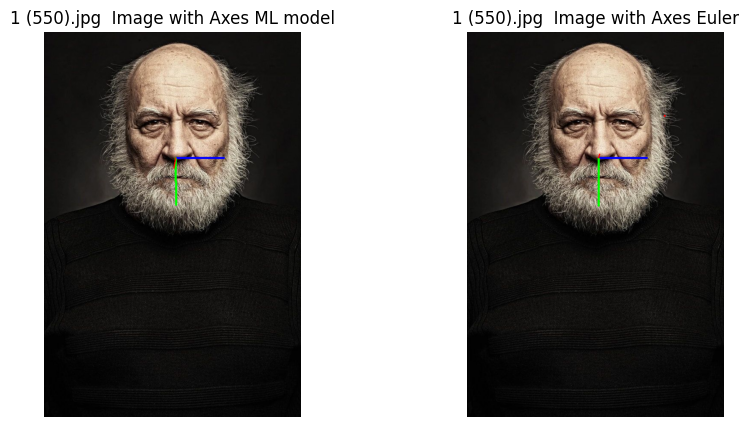

In [103]:
image_path = next(iter_3)
# image_path = f'{directory_2}/1 (1).jpg'
# Load the image
image = cv2.imread(image_path)


# Check if the image was loaded successfully
if image is not None:

    # Convert the image to RGB format (required for Mediapipe)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    # Process the image to extract landmark points
    results = face_mesh_module.process(image_rgb)

    # Check if landmarks were detected
    if results.multi_face_landmarks:
        face = results.multi_face_landmarks[0]
        
        width, height = image_rgb.shape[:2]
        
        angles = multi_output_regressor.predict(preprocess(face, width, height).reshape(1,-1))
        pitch, yaw, roll = angles[0,0], angles[0,1], angles[0,2]
        center = face.landmark[1]
        print(pitch, yaw, roll)
        image_with_axes = draw_axis(image_rgb, pitch, yaw, roll, tdx = center.x * height, tdy = center.y * width , size = width/8)
        # Create subplots

        # Plot the original image
        tit = image_path.split("Humans/")[-1]
        print(tit)
#         plt.set_title(f'{tit}  Image with Axes True')
        img_w, img_h = image_rgb.shape[:2]
        face_3d = []
        face_2d = []
        for idx, lm in enumerate(face.landmark):
                if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                    if idx == 1:
                        nose_2d = (lm.x * img_w, lm.y * img_h)
                        nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                    x, y = int(lm.x * img_w), int(lm.y * img_h)

                    # Get the 2D Coordinates
                    face_2d.append([x, y])

                    # Get the 3D Coordinates
                    face_3d.append([x, y, lm.z])       
            
        # Convert it to the NumPy array
        face_2d = np.array(face_2d, dtype=np.float64)

        # Convert it to the NumPy array
        face_3d = np.array(face_3d, dtype=np.float64)

        # The camera matrix
        focal_length = 1 * width

        cam_matrix = np.array([ [focal_length, 0, width / 2],
                                [0, focal_length, height / 2],
                                [0, 0, 1]])

        # The distortion parameters
        dist_matrix = np.zeros((4, 1), dtype=np.float64)

        # Solve PnP
        success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

        # Get rotational matrix
        rmat, jac = cv2.Rodrigues(rot_vec)

        # Get angles
        angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

        # Get the y rotation degree
        x = angles[0] * 2 * np.pi
        y = angles[1] * 2 * np.pi
        z = angles[2] *  2 * np.pi
        

        # Display the nose direction
        nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vec, trans_vec, cam_matrix, dist_matrix)

        p1 = (int(nose_2d[0]), int(nose_2d[1]))
        p2 = (int(nose_2d[0] + y * 10) , int(nose_2d[1] - x * 10))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.line(image, p1, p2, (255, 0, 0), 3)
        print(x, y, z)
        image_with_axes2 = draw_axis(image, x, y, z, tdx = center.x * height, tdy = center.y * width, size =  width / 8)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image_with_axes)
        axes[0].set_title(f'{tit}  Image with Axes ML model')
        axes[0].axis('off')
        # Plot the image with axes
        axes[1].imshow(image_with_axes2)
        axes[1].set_title(f'{tit}  Image with Axes Euler')
        axes[1].axis('off')
        plt.show()

else:
    print(f"Error: Unable to load the image from {image_path}.")
